In [1]:
import pandas as pd
import numpy as np
import os
from scipy.ndimage import rotate
import scipy.ndimage
from joblib import Parallel, delayed
import multiprocessing
import itertools
import pydicom
import SimpleITK as sitk
from scipy.ndimage import zoom 

#Code from existing github repo provided by UC Irvine dataset
from utils.equalizer import histEq
from utils.utils import cutCube

# Functions for DICOM Image Loading

In [2]:
# Modified DICOM loading functions for newer pydicom versions
def load_scan(path2scan):
    if (path2scan.split('.')[-1] == 'mhd') or (path2scan.split('.')[-1] == 'raw'):
        return load_mhd(path2scan)
    elif path2scan.split('.')[-1] == 'dcm':
        return load_dicom(os.path.split(path2scan)[0]) #pass containing directory
    elif os.path.isdir(path2scan) and any(f.endswith('.dcm') for f in os.listdir(path2scan)):
        return load_dicom(path2scan)
    else:
        raise Exception('No valid scan [series] found in given file/directory')

def load_mhd(path2scan):
    itkimage = sitk.ReadImage(path2scan)
    scan = sitk.GetArrayFromImage(itkimage)
    spacing = np.flip(np.array(itkimage.GetSpacing()),axis=0)
    orientation = np.transpose(np.array(itkimage.GetDirection()).reshape((3, 3)))
    origin = np.flip(np.array(itkimage.GetOrigin()),axis=0)
    return scan, spacing, orientation, origin, None

def load_dicom(path2scan_dir):
    dicom_folder = path2scan_dir
    dcms = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]
    if not dcms:
        raise Exception(f"No DICOM files found in {dicom_folder}")
    
    first_slice_data = pydicom.dcmread(os.path.join(path2scan_dir, dcms[0]))
    first_slice = first_slice_data.pixel_array
    orientation = np.transpose(first_slice_data.ImageOrientationPatient)
    spacing_xy = np.array(first_slice_data.PixelSpacing, dtype=float)
    spacing_z = float(first_slice_data.SliceThickness)
    spacing = np.array([spacing_z, spacing_xy[1], spacing_xy[0]])

    scan = np.zeros((len(dcms), first_slice.shape[0], first_slice.shape[1]))
    raw_slices = []
    indexes = []
    
    for dcm in dcms:
        slice_data = pydicom.dcmread(os.path.join(dicom_folder, dcm))
        slice_data.filename = dcm
        raw_slices.append(slice_data)
        indexes.append(float(slice_data.ImagePositionPatient[2]))
    
    indexes = np.array(indexes, dtype=float)
    raw_slices = [x for _, x in sorted(zip(indexes, raw_slices))]
    
    try:
        origin = np.array(raw_slices[0][0x00200032].value)
        origin = np.array([origin[2], origin[1], origin[0]])
    except:
        origin = np.zeros(3)

    for i, slice_obj in enumerate(raw_slices):
        scan[i, :, :] = slice_obj.pixel_array
    
    return scan, spacing, orientation, origin, raw_slices

def scale_scan(scan, spacing, factor=1):
    resize_factor = factor * spacing
    new_real_shape = scan.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / scan.shape
    new_spacing = spacing / real_resize_factor
    scan_resized = scipy.ndimage.zoom(scan, real_resize_factor, mode='nearest')
    return scan_resized, resize_factor

def get_scaled_shape(shape, spacing):
    new_real_shape = shape * spacing
    return np.round(new_real_shape).astype(int)

def world2vox(world_coord, spacing, orientation, origin):
    world_coord = np.dot(np.linalg.inv(np.dot(orientation, np.diag(spacing))), world_coord - origin)
    if orientation[0, 0] < 0:
        vox_coord = (np.array([world_coord[0], world_coord[2], world_coord[1]])).astype(int)
    else:
        vox_coord = (np.array([world_coord[0], world_coord[1], world_coord[2]])).astype(int)
    return vox_coord

In [3]:
class LabeledExtractor:
    """
    Adapted extractor for labeled medical imaging dataset to meet new pydicom requirements
    """
    def __init__(self, 
                 labels_csv_path, 
                 dicom_base_dir, 
                 dst_path, 
                 norm_save_dir,
                 cube_shape=(32, 32, 32),
                 parallelize=False,
                 coordSystem='vox',
                 include_types=['FB', 'FM', 'TM'], 
                 augment=True):
        """
        Args:
            labels_csv_path: Path to labels file
            dicom_base_dir: Base directory containing DICOM scans organized by uuid
            dst_path: Where to save the processed dataset
            norm_save_dir: Where to save normalization parameters
            cube_shape: Size of extracted 3D cubes
            parallelize: Whether to use multiprocessing
            coordSystem: 'vox' for voxel coordinates
            include_types: Which finding types to include
            augment: Whether to perform data augmentation
        """
        self.labels_csv_path = labels_csv_path
        self.dicom_base_dir = dicom_base_dir
        self.dst_path = dst_path
        self.norm_save_dir = norm_save_dir
        self.cube_shape = cube_shape
        self.parallelize = parallelize
        self.coordSystem = coordSystem
        self.include_types = include_types
        self.augment = augment
        
        # Load and filter the labels
        self.labels_df = pd.read_csv(labels_csv_path)
        self.labels_df = self.labels_df[self.labels_df['type'].isin(include_types)]
        
        # Filter out TB entries with 0,0,0 coordinates (no specific location)
        self.labels_df = self.labels_df[~((self.labels_df['type'] == 'TB') & 
                                        (self.labels_df['x'] == 0) & 
                                        (self.labels_df['y'] == 0) & 
                                        (self.labels_df['slice'] == 0))]
        
        print(f"Loaded {len(self.labels_df)} labeled samples")
        print(f"Types distribution:\n{self.labels_df['type'].value_counts()}")

    def extract(self, plot=True):
        """Extract and process all labeled samples"""
        print("Preparing extraction jobs...")
        
        jobs = []
        labels = []
        
        for idx, row in self.labels_df.iterrows():
            # Build path to DICOM scan
            scan_path = os.path.join(self.dicom_base_dir, str(row['uuid']))
            
            # Coordinate in z,y,x format (slice, y, x)
            coord = np.array([row['slice'], row['y'], row['x']])
            
            # Job format: [scan_path, coord, cube_shape, coordSystem, label_type]
            jobs.append([scan_path, coord, self.cube_shape, self.coordSystem, row['type']])
            labels.append(row['type'])
        
        print(f"Extracting {len(jobs)} samples...")
        
        if self.parallelize:
            num_cores = int(np.ceil(min(np.ceil(multiprocessing.cpu_count() * 0.75), len(jobs))))
            results = Parallel(n_jobs=num_cores)(delayed(self._process_job)(job) for job in jobs)
        else:
            results = []
            for i, job in enumerate(jobs):
                try:
                    result = self._process_job(job)
                    results.append(result)
                    if i % 10 == 0:
                        print(f"Processed {i+1}/{len(jobs)} samples")
                except Exception as e:
                    print(f"Failed to process sample {job[0]}: {e}")
                    results.append(None)
        
        # Collect successful extractions
        instances = []
        instance_labels = []
        
        for i, result in enumerate(results):
            if result is not None:
                cubes, label_type = result
                instances.extend(cubes)
                instance_labels.extend([label_type] * len(cubes))
        
        instances = np.array(instances)
        instance_labels = np.array(instance_labels)
        
        if len(instances) == 0:
            print("ERROR: No instances were successfully extracted!")
            print("This could be due to:")
            print("1. DICOM loading issues")
            print("2. Coordinate problems")
            print("3. Missing DICOM files")
            return None, None, None
        
        print(f"Successfully extracted {len(instances)} instances")
        
        # Preprocessing
        print("Equalizing the data...")
        eq = histEq(instances)
        instances = eq.equalize(instances)
        os.makedirs(self.norm_save_dir, exist_ok=True)
        eq.save(path=os.path.join(self.norm_save_dir, 'equalization.pkl'))

        print("Normalizing the data...")
        min_v = np.min(instances)
        max_v = np.max(instances)
        mean_v = np.mean(instances)
        norm_data = np.array([mean_v, min_v, max_v])
        instances = (instances - mean_v) / (max_v - min_v)
        np.save(os.path.join(self.norm_save_dir, 'normalization.npy'), norm_data)

        if plot:
            self._plot_samples(instances, instance_labels)

        # Save dataset and labels
        print("Saving the dataset...")
        np.save(self.dst_path, instances)
        np.save(self.dst_path.replace('.npy', '_labels.npy'), instance_labels)
        
        # Create label mapping
        label_mapping = {label: idx for idx, label in enumerate(np.unique(instance_labels))}
        print(f"Label mapping: {label_mapping}")
        
        return instances, instance_labels, label_mapping

    def _process_job(self, args):
        """Process single extraction job"""
        scan_path, coord, cube_shape, coordSystem, label_type = args
        
        try:
            # Load scan
            scan, spacing, orientation, origin, raw_slices = load_scan(scan_path)
            
            # Convert coordinates if needed
            if coordSystem == 'world':
                coord = world2vox(coord, spacing, orientation, origin)
            
            # Extract the base cube with padding
            init_cube_shape = get_scaled_shape(np.array(cube_shape) + 8, 1/spacing)
            clean_cube_unscaled = cutCube(scan, coord, init_cube_shape, padd=-1000)
            
            # Scale the cube
            scaled_cube, resize_factor = scale_scan(clean_cube_unscaled, spacing)
            
            # Data augmentation
            if self.augment:
                augmented_cubes = self._augment_instance(scaled_cube)
            else:
                augmented_cubes = [scaled_cube]
            
            # Trim to final shape
            final_cubes = []
            for cube in augmented_cubes:
                center = np.array(cube.shape) // 2
                final_cube = cutCube(cube, center, cube_shape, padd=-1000)
                if final_cube.shape == tuple(cube_shape):  # Only keep properly shaped cubes
                    final_cubes.append(final_cube)
            
            return final_cubes, label_type
            
        except Exception as e:
            print(f"Error processing {scan_path}: {e}")
            return None

    def _augment_instance(self, x0):
        """Data augmentation similar to original code but simplified"""
        augmented = [x0]  # Original
        
        # Flips
        augmented.append(np.flip(x0, 1))  # x flip
        augmented.append(np.flip(x0, 2))  # y flip
        
        # Small shifts
        augmented.append(scipy.ndimage.shift(x0, (0, 2, 2), mode='constant'))
        augmented.append(scipy.ndimage.shift(x0, (0, -2, 2), mode='constant'))
        
        # Small rotations
        for angle in [15, 30, 45, 90, 180]:
            rotated = rotate(x0, angle, axes=(1, 2), mode='reflect', reshape=False)
            augmented.append(rotated)
        
        # Filter out invalid shapes
        valid_cubes = []
        for cube in augmented:
            if cube.shape[0] > 0 and cube.shape[1] > 0 and cube.shape[2] > 0:
                valid_cubes.append(cube)
        
        return valid_cubes

    def _plot_samples(self, instances, labels):
        """Plot sample instances with their labels"""
        import matplotlib.pyplot as plt
        
        # Select random samples from each class
        unique_labels = np.unique(labels)
        samples_per_class = min(5, len(instances) // len(unique_labels))
        
        fig, axes = plt.subplots(len(unique_labels), samples_per_class, 
                                figsize=(samples_per_class * 3, len(unique_labels) * 3))
        
        if len(unique_labels) == 1:
            axes = axes.reshape(1, -1)
        
        for i, label in enumerate(unique_labels):
            label_indices = np.where(labels == label)[0]
            selected_indices = np.random.choice(label_indices, 
                                              min(samples_per_class, len(label_indices)), 
                                              replace=False)
            
            for j, idx in enumerate(selected_indices):
                middle_slice = instances[idx].shape[0] // 2
                axes[i, j].imshow(instances[idx][middle_slice, :, :], cmap='bone')
                axes[i, j].set_title(f'{label}')
                axes[i, j].axis('off')
        
        plt.tight_layout()
        plt.suptitle('Sample Extracted Instances by Type')
        plt.show()


In [4]:
class LabeledDataLoader:
    """
    Data loader for labeled dataset - modified for classification
    """
    def __init__(self, dataset_path, labels_path, normdata_path, img_res=(32, 32, 32)):
        self.normdata_path = normdata_path
        self.img_res = img_res
        
        print("Loading preprocessed dataset...")
        self.data = np.load(dataset_path)
        self.labels = np.load(labels_path)
        
        # Create label mapping
        self.unique_labels = np.unique(self.labels)
        self.label_to_idx = {label: idx for idx, label in enumerate(self.unique_labels)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        
        # Convert labels to indices
        self.label_indices = np.array([self.label_to_idx[label] for label in self.labels])
        
        # Format for neural network
        self.data = self.data.reshape((len(self.data), self.img_res[0], self.img_res[1], self.img_res[2], 1))
        
        print(f"Loaded {len(self.data)} samples")
        print(f"Label distribution: {dict(zip(*np.unique(self.labels, return_counts=True)))}")

    def load_batch(self, batch_size=32, shuffle=True):
        """Load batches for training"""
        if shuffle:
            indices = np.random.permutation(len(self.data))
        else:
            indices = np.arange(len(self.data))
        
        n_batches = len(self.data) // batch_size
        
        for i in range(n_batches):
            batch_indices = indices[i * batch_size:(i + 1) * batch_size]
            batch_data = self.data[batch_indices]
            batch_labels = self.label_indices[batch_indices]
            
            yield batch_data, batch_labels

# Import Dataset


Using DICOM directory: /mnt/c/Users/nhanj/Desktop/deepfakes+medical+image+tamper+detection/data/Tampered Scans/Experiment 1 - Blind
Loaded 118 labeled samples
Types distribution:
type
FB    61
FM    34
TM    23
Name: count, dtype: int64
Looking for labels at: /mnt/c/Users/nhanj/Desktop/deepfakes+medical+image+tamper+detection/data/Tampered Scans/labels_exp1.csv
Looking for DICOM scans at: /mnt/c/Users/nhanj/Desktop/deepfakes+medical+image+tamper+detection/data/Tampered Scans/Experiment 1 - Blind
Preparing extraction jobs...
Extracting 118 samples...
Processed 1/118 samples
Processed 11/118 samples
Processed 21/118 samples
Processed 31/118 samples
Processed 41/118 samples
Processed 51/118 samples
Processed 61/118 samples
Processed 71/118 samples
Processed 81/118 samples
Processed 91/118 samples
Processed 101/118 samples
Processed 111/118 samples
Successfully extracted 1180 instances
Equalizing the data...
Normalizing the data...


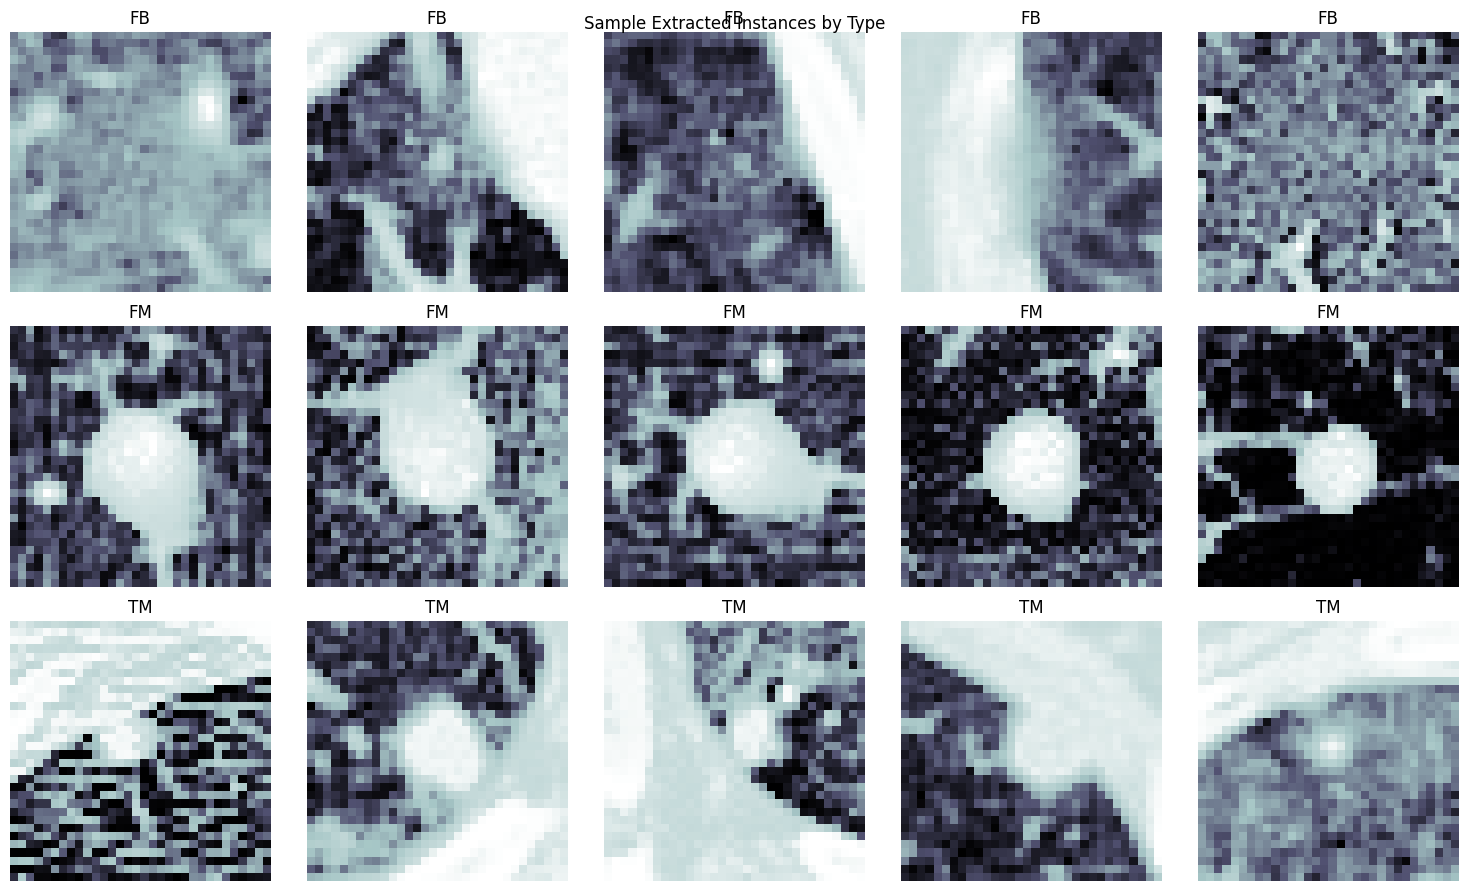

Saving the dataset...
Label mapping: {np.str_('FB'): 0, np.str_('FM'): 1, np.str_('TM'): 2}
Loading preprocessed dataset...
Loaded 1180 samples
Label distribution: {np.str_('FB'): np.int64(610), np.str_('FM'): np.int64(340), np.str_('TM'): np.int64(230)}
Label mapping: {np.str_('FB'): 0, np.str_('FM'): 1, np.str_('TM'): 2}


In [5]:
# Configuration for dicom dataset (make sure you change to your Windows path if you want to run it)
base_path = os.path.expanduser("/mnt/c/Users/nhanj/Desktop/deepfakes+medical+image+tamper+detection/data/Tampered Scans/")
labels_csv = os.path.join(base_path, "labels_exp1.csv")

# DICOM in the "Experiment 1 - Blind" subdirectory
dicom_dir = os.path.join(base_path, "Experiment 1 - Blind")


print(f"\nUsing DICOM directory: {dicom_dir}")

output_dataset = "tampered_scans_dataset.npy"
normalization_dir = "tampered_scans_normalization"

# Extract and preprocess
extractor = LabeledExtractor(
    labels_csv_path=labels_csv,
    dicom_base_dir=dicom_dir,
    dst_path=output_dataset,
    norm_save_dir=normalization_dir,
    cube_shape=(32, 32, 32),
    include_types=['FB', 'FM', 'TM'], 
    augment=True,
    parallelize=False  
)

print(f"Looking for labels at: {labels_csv}")
print(f"Looking for DICOM scans at: {dicom_dir}")

    
instances, labels, label_mapping = extractor.extract()

# Load for training
dataloader = LabeledDataLoader(
    dataset_path=output_dataset,
    labels_path=output_dataset.replace('.npy', '_labels.npy'),
    normdata_path=normalization_dir
)

print(f"Label mapping: {label_mapping}")

### On first glance you can see that the TM is typically a lesion attached to other part of the body or whatever the white is, whereas FM is isolated in itself. Convolutional Neural Network is a good modeling approach for this

In [13]:
#Creating Dataframe for Experiment 1 data (Tampered Scans)
from sklearn.preprocessing import LabelEncoder

labels_path = "/mnt/c/Users/nhanj/Desktop/deepfakes+medical+image+tamper+detection/data/Tampered Scans/labels_exp1.csv"

df = pd.read_csv(labels_path)
print(df.head())
print("Overview of DF:", df.info())
print()
print("Unique Value Counts:",df.nunique())
print()
print("Missing Value Count:", df.isnull().sum())

  type  uuid  slice    x    y
0   FB  1280    100  323  381
1   FB  1009     76  354  288
2   FB  7794     79  163  191
3   FB  7794     94  338  243
4   FB  2997     45  156  135
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    133 non-null    object
 1   uuid    133 non-null    int64 
 2   slice   133 non-null    int64 
 3   x       133 non-null    int64 
 4   y       133 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 5.3+ KB
Overview of DF: None

Unique Value Counts: type      4
uuid     80
slice    92
x        97
y        86
dtype: int64

Missing Value Count: type     0
uuid     0
slice    0
x        0
y        0
dtype: int64


In [21]:
print("Count by Type:", df.type.value_counts().sort_values(ascending=False))

Count by Type: type
FB    61
FM    34
TM    23
TB    15
Name: count, dtype: int64


### Clear Class Imbalance: Majority Class is FB (False Benign), meaning majority of scans are deepfake benign lung tumors.

In [23]:
df_no_coordinates = df[((df['x'] == 0) & (df['y'] == 0) & (df['slice'] == 0))]
df_no_coordinates.head()

,type,uuid,slice,x,y
95,TB,6644,0,0,0
96,TB,1531,0,0,0
97,TB,1779,0,0,0
98,TB,1779,0,0,0
99,TB,1779,0,0,0


In [25]:
print("Count by Type:", df_no_coordinates.type.value_counts().sort_values(ascending=False))

Count by Type: type
TB    15
Name: count, dtype: int64


### TB Class (and all its samples) do not have a specifically mapped cancerous area on the scan, thus remove the TB class from the DF, given it will disrupt analysis and modeling.

In [ ]:
#Remove TB Class
df = df[df['type'] != 'TB']
print("Count by Type:", df.type.value_counts().sort_values(ascending=False))

Count by Type: type
FB    61
FM    34
TM    23
Name: count, dtype: int64


In [40]:
#Encode Labels on DF
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])
print(df.sample(5))
print()
print('Label Encoded Types (Classes):', le.classes_)

    type  uuid  slice    x    y  type_encoded
7     FB  2997     70   85  197             0
59    FB  2494     64  333  370             0
112   TM  2244     65  294  360             2
41    FB  1883    123  358  374             0
38    FB  3251    304  145  400             0

Label Encoded Types (Classes): ['FB' 'FM' 'TM']


## Convolutional Neural Network (2D): Evaluating Dicom Images per Slice (2D)

### Data preprocessing



Correcting for class imbalance challenge:

In [46]:
# randomly draw 23 examples from each class (23 is min. sample count across all 3 classes)
df_FB = df[df.type_encoded.eq(0)].sample(
    n=23,
    replace=False
)

df_FM = df[df.type_encoded.eq(1)].sample(
    n=23,
    replace=False
)

df_TM = df[df.type_encoded.eq(2)].sample(
    n=23,
    replace=False
)

df_balanced = pd.concat([df_FB, df_FM, df_TM], axis=0)

# shuffle df_balanced
df_balanced = df_balanced.sample(frac=1, random_state=42) # frac=1 retains all the data
df_balanced.reset_index(drop=True, inplace=True) # reset index

print('After preprocessing, our data:')
df_balanced.head()

After preprocessing, our data:


,type,uuid,slice,x,y,type_encoded
0,FB,1883,89,128,336,0
1,FB,2997,70,85,197,0
2,TM,1871,149,411,216,2
3,FB,1883,123,358,374,0
4,TM,2131,211,385,307,2


In [53]:
#Add Image Path to each row for processing
#uuid is patient ID
df_balanced['dcm_path'] = df_balanced.apply(lambda row: os.path.join(dicom_dir, str(row["uuid"]), f"{row['slice']}.dcm"), axis=1)
df.shape

(118, 6)

In [55]:
# Augmentation setup to create synthetic data, as our current DF is quite low in sample size (118).
# We will randomly choose these with the p= as the probability of doing that thing
from albumentations import HorizontalFlip, VerticalFlip, ShiftScaleRotate, RandomBrightnessContrast, GaussianBlur, CoarseDropout
import albumentations as A

augment = A.Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    RandomBrightnessContrast(p=0.3),
    GaussianBlur(p=0.2)
])

/home/nhanj/anaconda3/envs/py3jp/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [58]:
# Read, resize, augment DICOM image data
import cv2

image_data = []
image_labels = []
label_map = {"FB": 0, "FM": 1, "TM": 2}
image_size = (256, 256)
for _, row in df_balanced.iterrows():
    try:
        ds = pydicom.dcmread(row["dcm_path"])
        img = ds.pixel_array.astype(np.float32)
        img = cv2.resize(img, image_size)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize pixel values to [0,1] since not all scans are same pixel range

        for _ in range(20): # Edit this number to change how many augmentations image per sample image
            aug = augment(image=img)["image"]
            image_data.append(aug.flatten())
            image_labels.append(row["type_encoded"])
    except Exception as e:
        print(f"Failed to process {row['dcm_path']}: {e}")

In [61]:
print(image_data[:1])
print(image_labels[:1])


[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]
[0]


In [1]:
#Creating X of images and Y (Labels)
X_images = np.array(image_data)
Y = image_labels
print(X[:1])
print(Y[:1])

# Drop 'type' and 'type_encoded' columns to create df of features
df_features = df_balanced.drop(columns=['type', 'type_encoded'])

# Convert DataFrame to NumPy array
features_array = df_features.to_numpy()

print(X_images.shape[0])
print(features_array.shape[0])


NameError: name 'np' is not defined